In [1]:
# init
import findspark
findspark.init()

In [2]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Start Spark session
spark = SparkSession.builder.appName("Amazon Fine Food Reviews Classification").getOrCreate()

In [4]:
# Load dataset
df = spark.read.csv('Reviews.csv', header=True, inferSchema=True)
df.show(100)

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

In [5]:
# Filter the dataset to include only Scores between 1 and 5
df_filtered = df.filter(df['Score'].between(1, 5))
score_counts_filtered = df_filtered.groupBy('Score').count()
score_counts_filtered.show()

+-----+------+
|Score| count|
+-----+------+
|    3| 42502|
|    5|361648|
|    1| 52635|
|    4| 80141|
|    2| 29877|
+-----+------+



In [6]:
# Drop missing values
df = df.dropna()

In [7]:
# Labeling: Score > 3 is positive (label = 1), others are negative (label = 0)
df = df.withColumn("label", (df.Score > 3).cast("integer"))  # 1 for positive, 0 for negative

In [8]:
# Split data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

In [9]:
# Process tokenization, stopwords removal, and feature extraction
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [10]:
# Decision Tree classifier
dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label")
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, scaler, dt])  # Use Decision Tree in the pipeline

In [13]:
try:
    model = pipeline.fit(train_data)
except Exception as e:
    print(f"Error during model fitting: {e}")

Error during model fitting: An error occurred while calling o62.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 23.0 failed 1 times, most recent failure: Lost task 15.0 in stage 23.0 (TID 193) (Aarsy executor driver): java.lang.RuntimeException: Labels MUST NOT be Null or NaN
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodege

In [15]:
try:
    predictions = model.transform(test_data)
except Exception as e:
    print(f"Error during predictions: {e}")

Error during predictions: name 'model' is not defined


In [17]:
try:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Test Accuracy: {accuracy}")
except Exception as e:
    print(f"Error during evaluation: {e}")

Error during evaluation: name 'predictions' is not defined


In [18]:
# Display the model accuracy
print(f"Test Accuracy: {accuracy}")

NameError: name 'accuracy' is not defined

C:\Users\ARSY ATHALLAH\AppData\Local\Temp\ipykernel_11048\3063997087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")


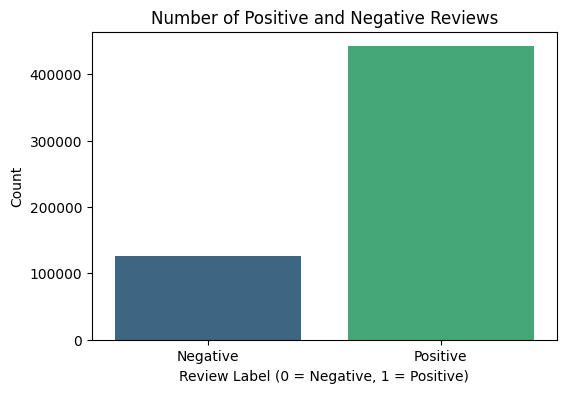

In [19]:
# Visualization of positive and negative reviews
df_pandas = df.select('label').toPandas()
review_counts = df_pandas['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Review Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()